# Bitcoin Analysis rev2

### Modules used in this assignment

In [2]:
from sklearn.ensemble import GradientBoostingClassifier as GB
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import AdaBoostClassifier as AB
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.neural_network import MLPClassifier as NN
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut as LOO
from sklearn.model_selection import KFold as KF
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef as mcc
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler  
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

### Dataset

In [3]:
# which dataset?
to_test = 'bitcoin-day'

# dataset selection
nm = ['bitcoin-day','bitcoin-min']
opt = nm.index(to_test)
# format:  ['filepath','num_features','attribute_to_predict']
options = [['cryptocurrencypricehistory/bitcoin_dataset.csv',27,'price_increases'],['bitcoin-historical-data/btc-30min.csv',8,'price_increases_30']]

# filename
f = options[opt][0]
# features available
num_feats = options[opt][1]
# prediction attribute
attribute = options[opt][2]

# load file
data = pd.read_csv(f)
# features
names = list(data.columns.values)
names = names[1:len(names)]

# label encoding
if opt == 1:
    data = data.apply(LabelEncoder().fit_transform)

# split targets from attributes
X = data.iloc[:,1:num_feats]
Y = data[attribute]

In [4]:
print("Binary Classification:  Preliminaries\n-------------------------------------")
print("The price rises %.2f%% of the time and falls %.2f%% of the time" % (np.sum(Y)/float(len(Y))*100,(1-np.sum(Y)/float(len(Y)))*100))
print("If we predict the price will fall every single day, our accuracy will be %.2f%%" % ((1-np.sum(Y)/float(len(Y)))*100))

Binary Classification:  Preliminaries
-------------------------------------
The price rises 45.75% of the time and falls 54.25% of the time
If we predict the price will fall every single day, our accuracy will be 54.25%


### Feature Selection

First, we use a model _not_ being evaluated in this assigment to visualize feature importance.

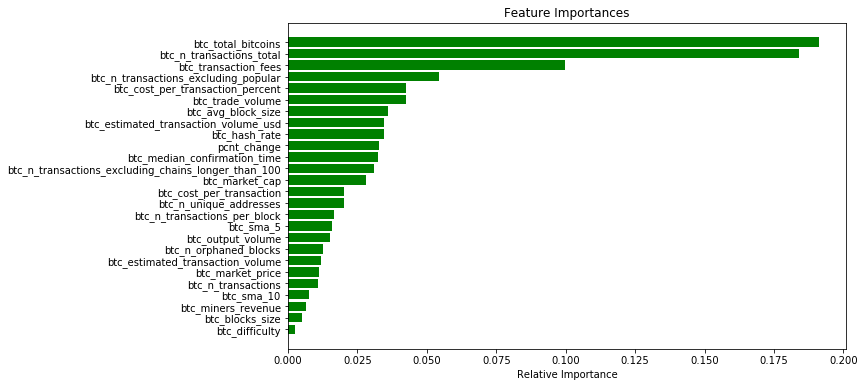

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# estimator
estimator = GB(n_estimators=200, learning_rate=0.001, max_depth=8, random_state=5)
estimator.fit(X_train, Y_train)

# plot feature importance
features = data.columns[1:num_feats]
importances = estimator.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10,6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], 
         color='g', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

Next, we use recursive feature elimination to reduce the number of attributes from 12 to 3.  We transform X, the input attributes, to reflect this choice.

In [6]:
# RFE using estimator defined above
selector = RFE(estimator, 8, step=1) # recursive feature elimination
selector = selector.fit(X_train, Y_train)
print(selector.ranking_) # value at [i] represents the importance of the given feature
X_reduced = selector.transform(X) # truncate the feature set

[15  1  2  1 18  1 14  5  3 10 19 17  1  1  7  8 11  1  1  1  9 12  4  6 13
 16]


In [7]:
# returns indices of array elements matching a specified value
def find(lst, val):
    return [i for i, x in enumerate(lst) if x==val]
# list the features selected for use in our evaluation
feats_idx = find(list(selector.ranking_),1) # indices of top features
selected_feats = features[feats_idx]
print("Selected Features:")
print(list(selected_feats))

Selected Features:
['btc_total_bitcoins', 'btc_trade_volume', 'btc_avg_block_size', 'btc_transaction_fees', 'btc_cost_per_transaction_percent', 'btc_n_transactions_total', 'btc_n_transactions_excluding_popular', 'btc_n_transactions_excluding_chains_longer_than_100']


### Random Forest

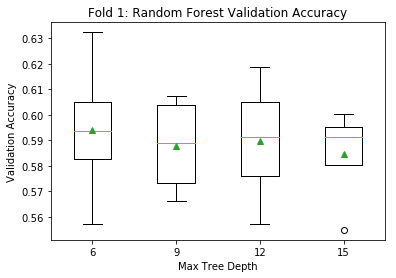

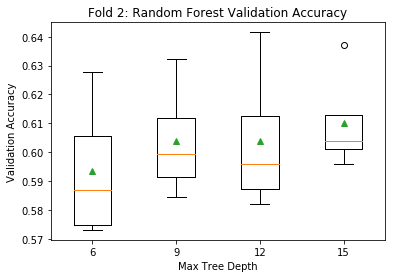

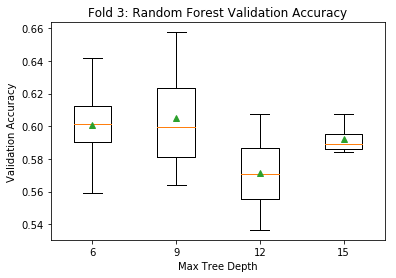

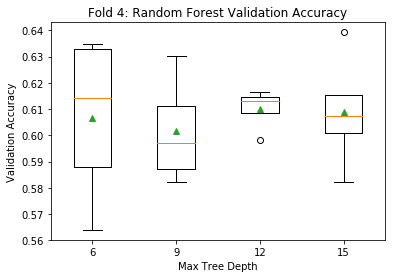

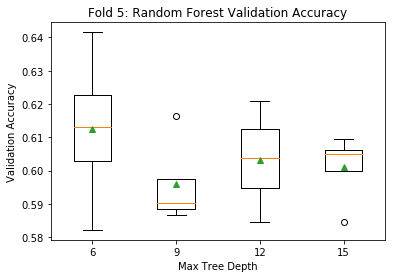


Fold	MCC	Accuracy
----	---	--------
1	0.300	62.10
2	0.178	58.90
3	0.287	61.64
4	0.193	59.36
5	0.175	56.39

Average test accuracy = 59.68%
Confusion Matrix
[[169 203]
 [ 87 271]]


In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, np.array(Y), test_size=0.25, random_state=42)

fold = 0
kf1 = KF(n_splits=5)
rf_test_scores = []
coeffs = []

# uncomment if train/test split not present (above)
#X_train = X
#X_train = np.array(X_train)
#Y_train = np.array(Y)

# first resampling
for train_index, test_index in kf1.split(X_train):
    # splits original data into train, test
    
    fold += 1
    xtrain, xtest = X_train[train_index], X_train[test_index]
    ytrain, ytest = Y_train[train_index], Y_train[test_index]
    kf2 = KF(n_splits=4)
    innerfold = 0
    val_scores = []
    val_scores_1 = []
    val_scores_2 = []
    val_scores_3 = []
    val_scores_4 = []
    
    # second resampling
    for train_idx, test_idx in kf2.split(xtrain):
        # splits original train into train2, test2
        models = []
        innerfold += 1
        xxtrain, xxval = xtrain[train_idx], xtrain[test_idx]
        yytrain, yyval = ytrain[train_idx], ytrain[test_idx]
        # models
        model_1 = RF(n_jobs=4,n_estimators=40,max_depth=6,class_weight='balanced').fit(xxtrain, yytrain)
        model_2 = RF(n_jobs=4,n_estimators=40,max_depth=9,class_weight='balanced').fit(xxtrain, yytrain)
        model_3 = RF(n_jobs=4,n_estimators=40,max_depth=12,class_weight='balanced').fit(xxtrain, yytrain)
        model_4 = RF(n_jobs=4,n_estimators=40,max_depth=15,class_weight='balanced').fit(xxtrain, yytrain)
        # validation accuracy
        val_scores_1.append(model_1.score(xxval, yyval))
        val_scores_2.append(model_2.score(xxval, yyval))
        val_scores_3.append(model_3.score(xxval, yyval))
        val_scores_4.append(model_4.score(xxval, yyval))
        models = [model_1, model_2, model_3, model_4]
    
    # average validation scores for model w/ given parameter
    val_scores = [np.mean(val_scores_1), np.mean(val_scores_2), np.mean(val_scores_3), np.mean(val_scores_4)] 
    
    boxdata = [val_scores_1, val_scores_2, val_scores_3, val_scores_4]
    labels = ['6','9','12','15']
    plt.figure()
    plt.boxplot(boxdata,labels=labels,showmeans=True)
    plt.xlabel("Max Tree Depth")
    plt.ylabel("Validation Accuracy")
    plt.title("Fold %d: Random Forest Validation Accuracy" % fold)
    plt.show()
    
    # pick model with best validation score use it for testing
    best_model_idx = val_scores.index(max(val_scores))
    model = models[best_model_idx]
    
    # test accuracy for this fold
    rf_test_scores.append(model.score(xtest, ytest))
    coeffs.append(mcc(ytest, model.predict(xtest)))

print("\nFold\tMCC\tAccuracy\n----\t---\t--------")
for i in range(len(coeffs)):
    print("%d\t%.3f\t%.2f" % (i+1,coeffs[i],rf_test_scores[i]*100))

# results of each testing phase
print("\nAverage test accuracy = %.2f%%" % (np.mean(rf_test_scores) * 100))

# outermost test set
preds = model.predict(X_test)
print("Confusion Matrix")
print(confusion_matrix(Y_test, preds))

### Adaboost

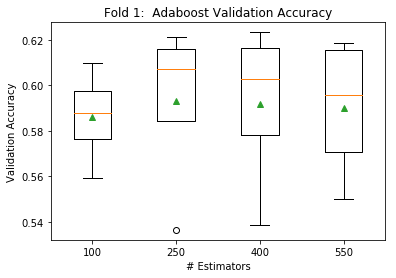

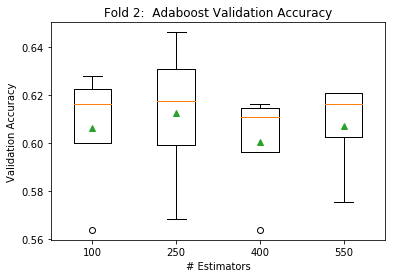

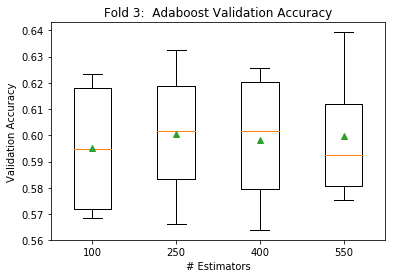

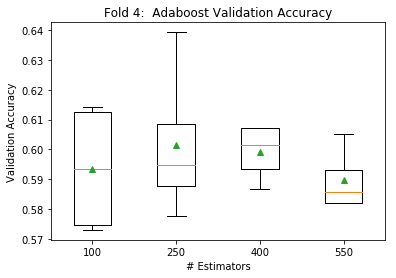

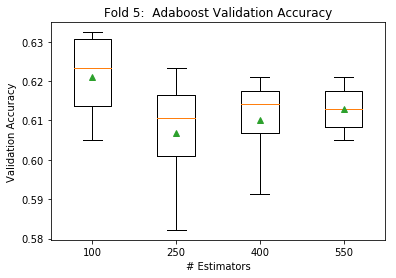


Fold	MCC	Accuracy
----	---	--------
1	0.245	62.33
2	0.227	61.42
3	0.243	62.33
4	0.159	58.22
5	0.153	57.31

Average test accuracy = 60.32%
Confusion Matrix
[[243 153]
 [146 188]]


In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, np.array(Y), test_size=0.25, random_state=24)

fold = 0
kf1 = KF(n_splits=5)
ab_test_scores = []
coeffs = []

# uncomment if train/test split not defined (above)
#X_train = X
#X_train = np.array(X_train)
#Y_train = np.array(Y)

# first resampling
for train_index, test_index in kf1.split(X_train):
    fold += 1
    xtrain, xtest = X_train[train_index], X_train[test_index]
    ytrain, ytest = Y_train[train_index], Y_train[test_index]
    kf2 = KF(n_splits=4)
    innerfold = 0
    val_scores = []
    val_scores_1 = []
    val_scores_2 = []
    val_scores_3 = []
    val_scores_4 = []
    
    # second resampling
    for train_idx, test_idx in kf2.split(xtrain):
        models = []
        innerfold += 1
        xxtrain, xxval = xtrain[train_idx], xtrain[test_idx]
        yytrain, yyval = ytrain[train_idx], ytrain[test_idx]
        # models
        model_1 = AB(n_estimators=100).fit(xxtrain, yytrain)
        model_2 = AB(n_estimators=250).fit(xxtrain, yytrain)
        model_3 = AB(n_estimators=400).fit(xxtrain, yytrain)
        model_4 = AB(n_estimators=550).fit(xxtrain, yytrain)
        # validation accuracy
        val_scores_1.append(model_1.score(xxval, yyval))
        val_scores_2.append(model_2.score(xxval, yyval))
        val_scores_3.append(model_3.score(xxval, yyval))
        val_scores_4.append(model_4.score(xxval, yyval))
        models = [model_1, model_2, model_3, model_4]
    
    # average validation score for each model in this fold
    val_scores = [np.mean(val_scores_1), np.mean(val_scores_2), np.mean(val_scores_3), np.mean(val_scores_4)] 
    
    # boxplot of validation scores
    boxdata = [val_scores_1, val_scores_2, val_scores_3, val_scores_4]
    labels = ['100','250','400','550']
    plt.figure()
    plt.boxplot(boxdata,labels=labels,showmeans=True)
    plt.xlabel("# Estimators")
    plt.ylabel("Validation Accuracy")
    plt.title("Fold %d:  Adaboost Validation Accuracy" % fold)
    plt.show()
    
    # pick model with best validation score use it for testing
    best_model_idx = val_scores.index(max(val_scores))
    model = models[best_model_idx]
    
    # test accuracy for this fold
    ab_test_scores.append(model.score(xtest, ytest))
    coeffs.append(mcc(ytest, model.predict(xtest)))

print("\nFold\tMCC\tAccuracy\n----\t---\t--------")
for i in range(len(coeffs)):
    print("%d\t%.3f\t%.2f" % (i+1,coeffs[i],ab_test_scores[i]*100))

# overall test accuracy
print("\nAverage test accuracy = %.2f%%" % (np.mean(ab_test_scores) * 100))

# confusion matrix
preds = model.predict(X_test)
print("Confusion Matrix")
print(confusion_matrix(Y_test, preds))

### Decision Tree

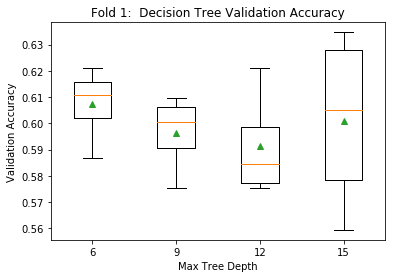

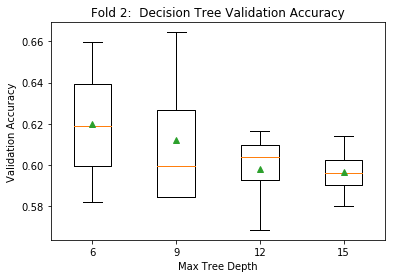

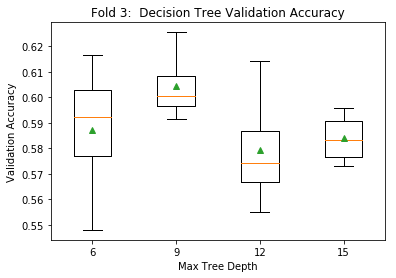

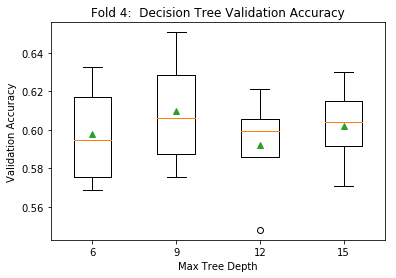

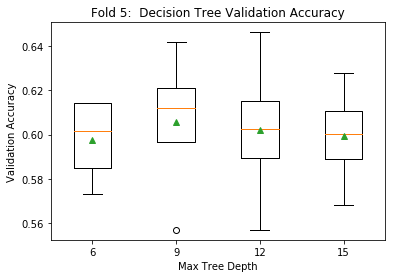


Fold	MCC	Accuracy
----	---	--------
1	0.230	61.64
2	0.173	57.76
3	0.282	64.16
4	0.228	60.96
5	0.245	61.64

Average test accuracy = 61.23%
Confusion Matrix
[[188 202]
 [105 235]]


In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, np.array(Y), test_size=0.25, random_state=16)

fold = 0
kf1 = KF(n_splits=5)
dt_test_scores = []
coeffs = []

# uncomment if train/test split not defined (above)
#X_train = X
#X_train = np.array(X_train)
#Y_train = np.array(Y)

# first resampling
for train_index, test_index in kf1.split(X_train):
    fold += 1
    xtrain, xtest = X_train[train_index], X_train[test_index]
    ytrain, ytest = Y_train[train_index], Y_train[test_index]
    kf2 = KF(n_splits=4)
    innerfold = 0
    val_scores = []
    val_scores_1 = []
    val_scores_2 = []
    val_scores_3 = []
    val_scores_4 = []
    
    # second resampling
    for train_idx, test_idx in kf2.split(xtrain):
        models = []
        innerfold += 1
        xxtrain, xxval = xtrain[train_idx], xtrain[test_idx]
        yytrain, yyval = ytrain[train_idx], ytrain[test_idx]
        # model
        model_1 = DT(max_depth=6,criterion='entropy').fit(xxtrain, yytrain)
        model_2 = DT(max_depth=9,criterion='entropy').fit(xxtrain, yytrain)
        model_3 = DT(max_depth=12,criterion='entropy').fit(xxtrain, yytrain)
        model_4 = DT(max_depth=15,criterion='entropy').fit(xxtrain, yytrain)
        # validation accuracy
        val_scores_1.append(model_1.score(xxval, yyval))
        val_scores_2.append(model_2.score(xxval, yyval))
        val_scores_3.append(model_3.score(xxval, yyval))
        val_scores_4.append(model_4.score(xxval, yyval))
        models = [model_1, model_2, model_3, model_4]
    
    # average validation scores for model w/ given parameter
    val_scores = [np.mean(val_scores_1), np.mean(val_scores_2), np.mean(val_scores_3), np.mean(val_scores_4)] 
    
    boxdata = [val_scores_1, val_scores_2, val_scores_3, val_scores_4]
    labels = ['6','9','12','15']
    plt.figure()
    plt.boxplot(boxdata,labels=labels,showmeans=True)
    plt.xlabel("Max Tree Depth")
    plt.ylabel("Validation Accuracy")
    plt.title("Fold %d:  Decision Tree Validation Accuracy" % fold)
    plt.show()
    
    # pick model with best validation score use it for testing
    best_model_idx = val_scores.index(max(val_scores))
    model = models[best_model_idx]
    
    # test accuracy for this fold
    dt_test_scores.append(model.score(xtest, ytest))
    coeffs.append(mcc(ytest, model.predict(xtest)))

print("\nFold\tMCC\tAccuracy\n----\t---\t--------")
for i in range(len(coeffs)):
    print("%d\t%.3f\t%.2f" % (i+1,coeffs[i],dt_test_scores[i]*100))

# results of each testing phase
print("\nAverage test accuracy = %.2f%%" % (np.mean(dt_test_scores) * 100))

# confusion matrix
preds = model.predict(X_test)
print("Confusion Matrix")
print(confusion_matrix(Y_test, preds))

### MLP

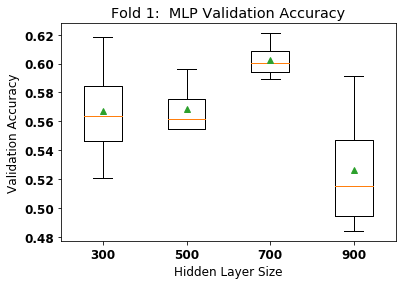

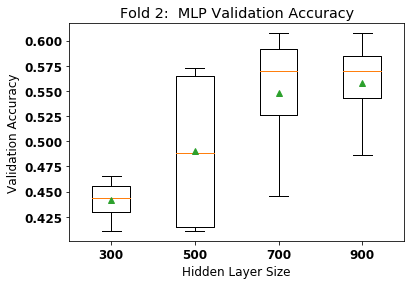

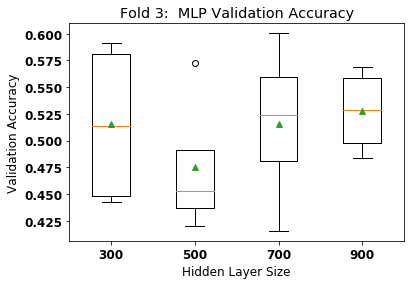

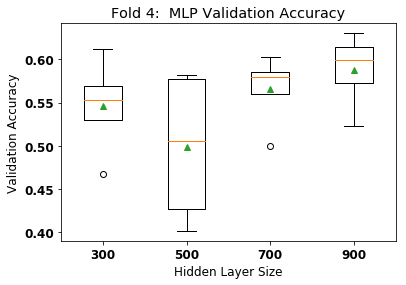

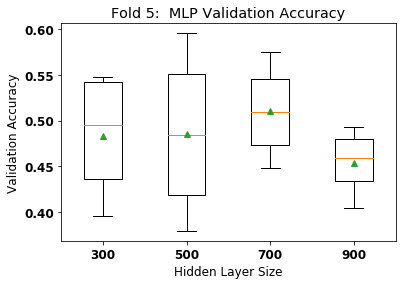


Fold	MCC	Accuracy
----	---	--------
1	0.229	56.39
2	0.001	50.23
3	0.072	43.84
4	0.000	53.20
5	0.134	56.85

Average test accuracy = 52.10%
Confusion Matrix
[[322  74]
 [235  99]]


In [84]:
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, np.array(Y), test_size=0.25, random_state=99)

fold = 0
kf1 = KF(n_splits=5)
nn_test_scores = []
coeffs = []

# uncomment if train/test split not defined (above)
#X_train = X
#X_train = np.array(X_train)
#Y_train = np.array(Y)

# first resampling
for train_index, test_index in kf1.split(X_train):
    fold += 1
    xtrain, xtest = X_train[train_index], X_train[test_index]
    ytrain, ytest = Y_train[train_index], Y_train[test_index]
    kf2 = KF(n_splits=4)
    innerfold = 0
    val_scores = []
    val_scores_1 = []
    val_scores_2 = []
    val_scores_3 = []
    val_scores_4 = []
    
    # second resampling
    for train_idx, test_idx in kf2.split(xtrain):
        models = []
        innerfold += 1
        xxtrain, xxval = xtrain[train_idx], xtrain[test_idx]
        yytrain, yyval = ytrain[train_idx], ytrain[test_idx]
        # model
        model_1 = NN(solver='adam',hidden_layer_sizes=(50,)).fit(xxtrain, yytrain)
        model_2 = NN(solver='adam',hidden_layer_sizes=(150,)).fit(xxtrain, yytrain)
        model_3 = NN(solver='adam',hidden_layer_sizes=(450,)).fit(xxtrain, yytrain)
        model_4 = NN(solver='adam',hidden_layer_sizes=(1350,)).fit(xxtrain, yytrain)
        # validation accuracy
        val_scores_1.append(model_1.score(xxval, yyval))
        val_scores_2.append(model_2.score(xxval, yyval))
        val_scores_3.append(model_3.score(xxval, yyval))
        val_scores_4.append(model_4.score(xxval, yyval))
        models = [model_1, model_2, model_3, model_4]
    
    # average validation scores for model w/ given parameter
    val_scores = [np.mean(val_scores_1), np.mean(val_scores_2), np.mean(val_scores_3), np.mean(val_scores_4)] 
    
    boxdata = [val_scores_1, val_scores_2, val_scores_3, val_scores_4]
    labels = ['50','150','450','1350']
    plt.figure()
    plt.boxplot(boxdata,labels=labels,showmeans=True)
    plt.xlabel("Hidden Layer Size")
    plt.ylabel("Validation Accuracy")
    plt.title("Fold %d:  MLP Validation Accuracy" % fold)
    plt.show()
    
    # pick model with best validation score use it for testing
    best_model_idx = val_scores.index(max(val_scores))
    model = models[best_model_idx]
    
    # test accuracy for this fold
    nn_test_scores.append(model.score(xtest, ytest))
    coeffs.append(mcc(ytest, model.predict(xtest)))

print("\nFold\tMCC\tAccuracy\n----\t---\t--------")
for i in range(len(coeffs)):
    print("%d\t%.3f\t%.2f" % (i+1,coeffs[i],nn_test_scores[i]*100))

# results of each testing phase
print("\nAverage test accuracy = %.2f%%" % (np.mean(nn_test_scores) * 100))

# confusion matrix
preds = model.predict(X_test)
print("Confusion Matrix")
print(confusion_matrix(Y_test, preds))

### k-Nearest Neighbor

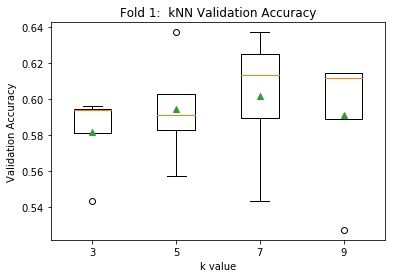

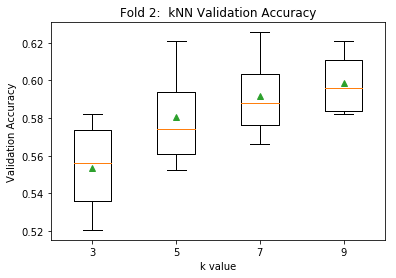

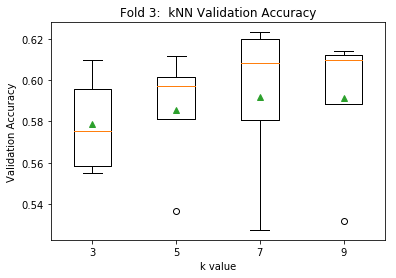

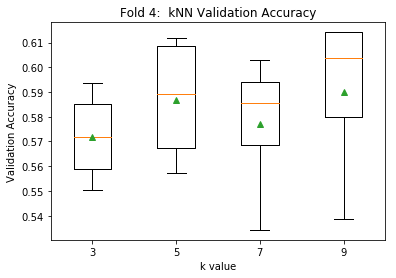

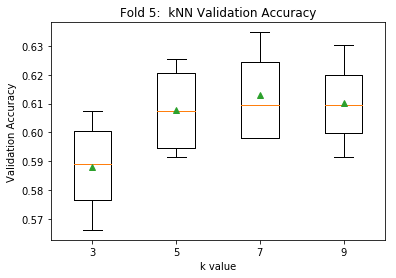


Fold	MCC	Accuracy
----	---	--------
1	0.192	59.82
2	0.236	61.64
3	0.186	59.82
4	0.254	63.01
5	0.066	53.42

Average test accuracy = 59.54%
Confusion Matrix
[[242 158]
 [127 203]]


In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, np.array(Y), test_size=0.25, random_state=66)


fold = 0
kf1 = KF(n_splits=5)
knn_test_scores = []
coeffs = []

# uncomment if train/test split not defined (above)
#X_train = X
#X_train = np.array(X_train)
#Y_train = np.array(Y)

# first resampling
for train_index, test_index in kf1.split(X_train):
    fold += 1
    xtrain, xtest = X_train[train_index], X_train[test_index]
    ytrain, ytest = Y_train[train_index], Y_train[test_index]
    kf2 = KF(n_splits=4)
    innerfold = 0
    val_scores = []
    val_scores_1 = []
    val_scores_2 = []
    val_scores_3 = []
    val_scores_4 = []
    
    # second resampling
    for train_idx, test_idx in kf2.split(xtrain):
        models = []
        innerfold += 1
        xxtrain, xxval = xtrain[train_idx], xtrain[test_idx]
        yytrain, yyval = ytrain[train_idx], ytrain[test_idx]
        # model
        model_1 = kNN(n_neighbors=3).fit(xxtrain, yytrain)
        model_2 = kNN(n_neighbors=5).fit(xxtrain, yytrain)
        model_3 = kNN(n_neighbors=7).fit(xxtrain, yytrain)
        model_4 = kNN(n_neighbors=9).fit(xxtrain, yytrain)
        # validation accuracy
        val_scores_1.append(model_1.score(xxval, yyval))
        val_scores_2.append(model_2.score(xxval, yyval))
        val_scores_3.append(model_3.score(xxval, yyval))
        val_scores_4.append(model_4.score(xxval, yyval))
        models = [model_1, model_2, model_3, model_4]
    
    # average validation scores for model w/ given parameter
    val_scores = [np.mean(val_scores_1), np.mean(val_scores_2), np.mean(val_scores_3), np.mean(val_scores_4)] 
    
    boxdata = [val_scores_1, val_scores_2, val_scores_3, val_scores_4]
    labels = ['3','5','7','9']
    plt.figure()
    plt.boxplot(boxdata,labels=labels,showmeans=True)
    plt.xlabel("k value")
    plt.ylabel("Validation Accuracy")
    plt.title("Fold %d:  kNN Validation Accuracy" % fold)
    plt.show()
    
    # pick model with best validation score use it for testing
    best_model_idx = val_scores.index(max(val_scores))
    model = models[best_model_idx]
    
    # test accuracy for this fold
    knn_test_scores.append(model.score(xtest, ytest))
    coeffs.append(mcc(ytest, model.predict(xtest)))

print("\nFold\tMCC\tAccuracy\n----\t---\t--------")
for i in range(len(coeffs)):
    print("%d\t%.3f\t%.2f" % (i+1,coeffs[i],knn_test_scores[i]*100))

# results of each testing phase
print("\nAverage test accuracy = %.2f%%" % (np.mean(knn_test_scores) * 100))

# confusion matrix
preds = model.predict(X_test)
print("Confusion Matrix")
print(confusion_matrix(Y_test, preds))

### Data Visualization

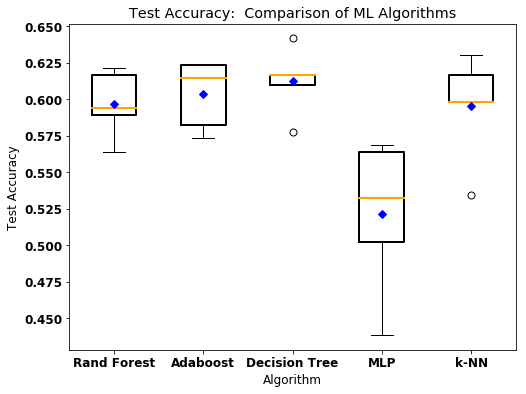

In [96]:
# overall test data
boxdata = [rf_test_scores, ab_test_scores, dt_test_scores, nn_test_scores, knn_test_scores]
labels = ['Rand Forest','Adaboost','Decision Tree','MLP','k-NN']
title = "Test Accuracy:  Comparison of ML Algorithms"

#formatting
font = {'size'   : 12, 'weight':'bold'}
plt.rc('font', **font)
boxprops = dict(linewidth=2, color='black')
flierprops = dict(marker='o', markeredgecolor='black',markerfacecolor='white', markersize=7, linestyle='none')
medianprops = dict(linestyle='-', linewidth=2, color='orange')
meanpointprops = dict(marker='D', markeredgecolor='blue', markerfacecolor='blue')

# boxplot
plt.figure(figsize=(8,6))
plt.boxplot(boxdata,labels=labels,showmeans=True,boxprops=boxprops,medianprops=medianprops,flierprops=flierprops, meanprops=meanpointprops)
plt.xlabel("Algorithm")
plt.ylabel("Test Accuracy")
plt.title(title)
plt.show()